Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only). <br>
Vocal channel (01 = speech, 02 = song). <br>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). <br>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion. <br>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). <br>
Repetition (01 = 1st repetition, 02 = 2nd repetition). <br>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female). <br>
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02) <br>
Speech (01) <br>
Fearful (06) <br>
Normal intensity (01) <br>
Statement "dogs" (02) <br>
1st Repetition (01) <br>
12th Actor (12) - Female (as the actor ID number is even) <br>

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [19]:
PATH = fr'/kaggle/input/ravdess-emotional-speech-audio/'
folders = os.listdir(PATH)
folders

['Actor_02',
 'Actor_17',
 'Actor_05',
 'Actor_16',
 'Actor_21',
 'Actor_01',
 'Actor_11',
 'Actor_20',
 'Actor_08',
 'Actor_15',
 'Actor_06',
 'Actor_12',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_04',
 'Actor_19',
 'Actor_10',
 'Actor_09',
 'audio_speech_actors_01-24',
 'Actor_14',
 'Actor_03',
 'Actor_13',
 'Actor_18',
 'Actor_07']

In [20]:
PATH = fr'/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
folders = os.listdir(PATH)
print(len(folders))
folders

24


['Actor_02',
 'Actor_17',
 'Actor_05',
 'Actor_16',
 'Actor_21',
 'Actor_01',
 'Actor_11',
 'Actor_20',
 'Actor_08',
 'Actor_15',
 'Actor_06',
 'Actor_12',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_04',
 'Actor_19',
 'Actor_10',
 'Actor_09',
 'Actor_14',
 'Actor_03',
 'Actor_13',
 'Actor_18',
 'Actor_07']

In [21]:
COLS = ['Path', 'Modality', 'Vocal channel', 'Emotion', 'Emotional intensity', 
        'Statement', 'Repetition', 'Actor']
df = pd.DataFrame(columns=COLS)
df

,Path,Modality,Vocal channel,Emotion,Emotional intensity,Statement,Repetition,Actor


In [22]:
i=0
for folder_name in os.listdir(PATH):
    folder_path =  PATH + folder_name + '/'
    
    for file_name in os.listdir(folder_path):
        df.loc[i, 'Path'] = folder_path + file_name
        file_name = file_name.split('.')[0]
#         print(file_name)
        df.loc[i, 'Modality'] = int(file_name.split('-')[0])
        df.loc[i, 'Vocal channel'] = int(file_name.split('-')[1])
        df.loc[i, 'Emotion'] = int(file_name.split('-')[2])
        df.loc[i, 'Emotional intensity'] = int(file_name.split('-')[3])
        df.loc[i, 'Statement'] = int(file_name.split('-')[4])
        df.loc[i, 'Repetition'] = int(file_name.split('-')[5])
        df.loc[i, 'Actor'] = int(file_name.split('-')[6])
        
        i+=1

In [23]:
df

,Path,Modality,Vocal channel,Emotion,Emotional intensity,Statement,Repetition,Actor
0,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,8,1,1,1,2
1,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,1,1,1,1,2
2,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,7,2,1,2,2
3,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,7,1,1,2,2
4,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,1,1,2,1,2
...,...,...,...,...,...,...,...,...
1435,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,6,1,1,2,7
1436,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,5,1,2,2,7
1437,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,4,2,1,1,7
1438,/kaggle/input/ravdess-emotional-speech-audio/a...,3,1,7,2,2,2,7


In [24]:
modality_dict = {1: 'full-AV', 2:'video-only', 3:'audio-only'}
vocal_channel_dict = {1:'speech', 2:'song'}
emotion_dict = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
emtional_intensity_dict = {1:'normal', 2:'strong'}
statement_dict ={1:"Kids are talking by the door", 2:"Dogs are sitting by the door"}
repetition_dict={1: '1st repetition', 2:'2nd repetition'}
actor_dict = {k: 'Female' if k % 2 == 0 else 'Male' for k in df['Actor']}

In [25]:
df.columns

Index(['Path', 'Modality', 'Vocal channel', 'Emotion', 'Emotional intensity',
       'Statement', 'Repetition', 'Actor'],
      dtype='object')

In [26]:
df_mapped = pd.DataFrame()
df_mapped['Modality'] = df['Modality'].map(modality_dict)
df_mapped['Vocal channel'] = df['Vocal channel'].map(vocal_channel_dict)
df_mapped['Emotion'] = df['Emotion'].map(emotion_dict)
df_mapped['Emotional intensity'] = df['Emotional intensity'].map(emtional_intensity_dict)
df_mapped['Statement'] = df['Statement'].map(statement_dict)
df_mapped['Repetition'] = df['Repetition'].map(repetition_dict)
df_mapped['Actor'] = df['Actor'].map(actor_dict)

df_mapped

,Modality,Vocal channel,Emotion,Emotional intensity,Statement,Repetition,Actor
0,audio-only,speech,surprise,normal,Kids are talking by the door,1st repetition,Female
1,audio-only,speech,neutral,normal,Kids are talking by the door,1st repetition,Female
2,audio-only,speech,disgust,strong,Kids are talking by the door,2nd repetition,Female
3,audio-only,speech,disgust,normal,Kids are talking by the door,2nd repetition,Female
4,audio-only,speech,neutral,normal,Dogs are sitting by the door,1st repetition,Female
...,...,...,...,...,...,...,...
1435,audio-only,speech,fear,normal,Kids are talking by the door,2nd repetition,Male
1436,audio-only,speech,angry,normal,Dogs are sitting by the door,2nd repetition,Male
1437,audio-only,speech,sad,strong,Kids are talking by the door,1st repetition,Male
1438,audio-only,speech,disgust,strong,Dogs are sitting by the door,2nd repetition,Male


In [27]:
df_mapped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Modality             1440 non-null   object
 1   Vocal channel        1440 non-null   object
 2   Emotion              1440 non-null   object
 3   Emotional intensity  1440 non-null   object
 4   Statement            1440 non-null   object
 5   Repetition           1440 non-null   object
 6   Actor                1440 non-null   object
dtypes: object(7)
memory usage: 122.3+ KB


In [28]:
df.to_csv('data.csv', index=False)

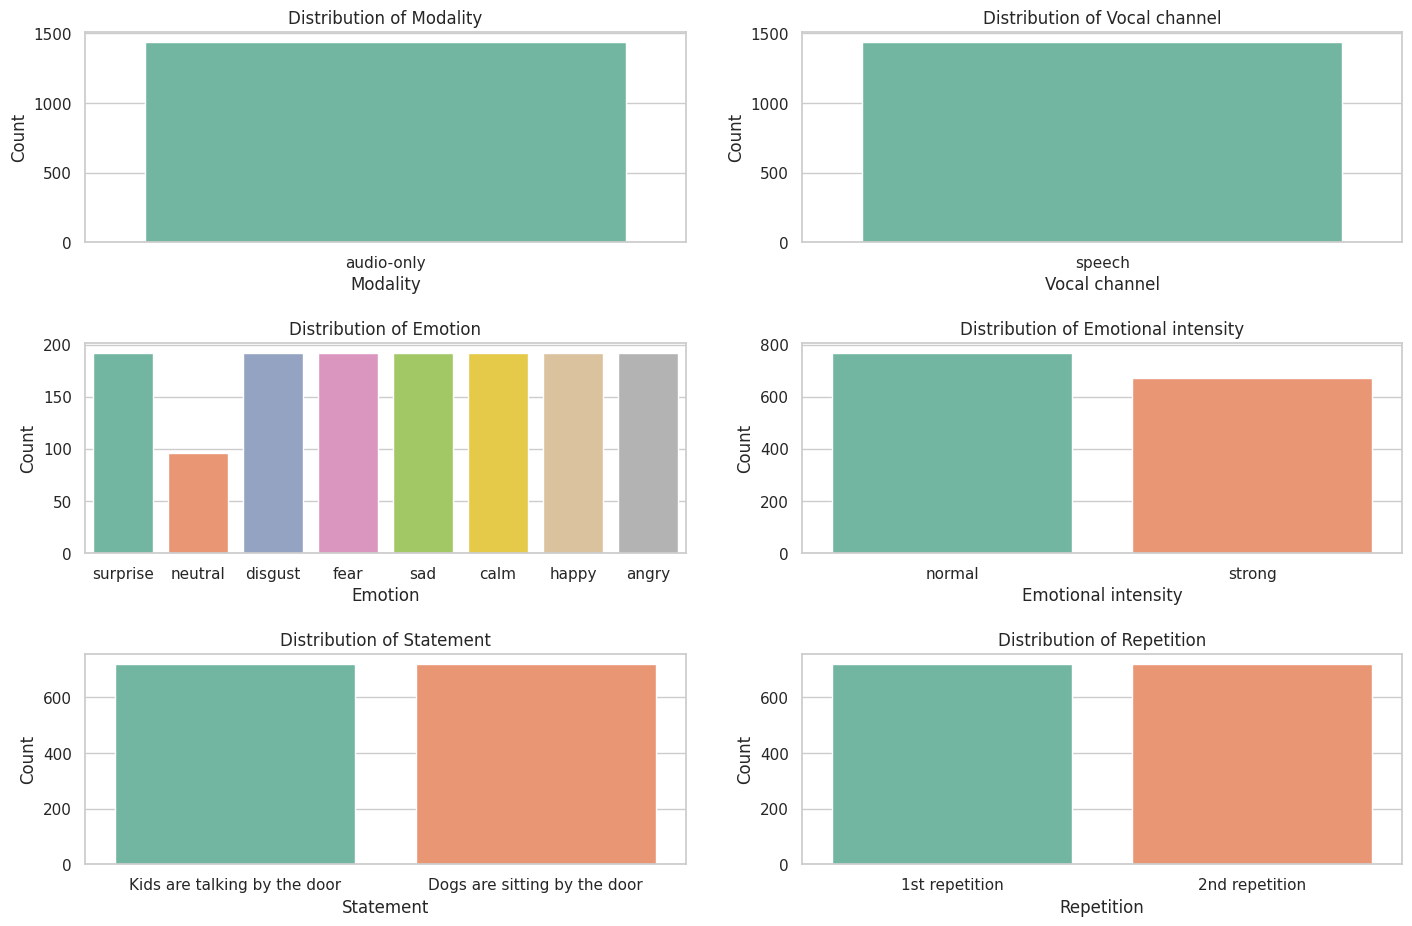

In [29]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))  # Adjust the grid size based on your columns
fig.tight_layout(pad=4.0)

columns = df.columns[1:]

for ax, column in zip(axes.flat, columns):
    sns.countplot(data=df_mapped, x=column, ax=ax, palette="Set2")
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    

for i in range(len(columns), axes.size):
    fig.delaxes(axes.flat[i])


plt.show()

In [61]:
def extract_features(file_name, mfcc_ft, chroma_ft, mel_ft):
    with sf.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        
        result = np.array([])
        
        if mfcc_ft:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
            result = np.hstack((result, mfccs.flatten()))
            
        if chroma_ft:
            stft = np.abs(librosa.stft(X, n_fft=1000))
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma.flatten()))
            
        if mel_ft:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel.flatten()))
            
    return result

In [62]:
Labels = [label for label in df['Emotion']]  
features = []

for i,path in enumerate(tqdm(df["Path"])):
    feat = extract_features(path, True, True, True)
#     print(feat.shape)
#     if(feat.shape[0]!=180):
#         print(i)
    features.append(feat)

100%|██████████| 1440/1440 [01:12<00:00, 19.83it/s]


In [63]:
features[0].shape

(128,)

In [64]:
def preprocess_audio(audio, target_length):
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]
    return audio

In [65]:
target_len = 100
padded_features = []

for feature in features:
    feature = preprocess_audio(feature, target_len)
    padded_features.append(feature)

padded_features = np.array(padded_features)
print(padded_features.shape)

(1440, 100)


In [66]:
print(len(features), len(Labels))
X = np.array(padded_features)
y = np.array(Labels)

1440 1440


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
X_train.shape

(1152, 100)

In [69]:
classifiers = {'Random Forest Classifier':RandomForestClassifier(n_estimators=100, random_state=0),
              'SVM Classifier': SVC(kernel='linear', random_state=0),
              'Logistic Regression Classifier': LogisticRegression(max_iter=300, random_state=0)}

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    print(f"{name} Report:")
    print(classification_report(y_test, preds))
    print(f'Accuracy: {accuracy_score(y_test, preds) * 100}%')
    print('\n------------------------------------------\n')

Random Forest Classifier Report:
              precision    recall  f1-score   support

           1       0.50      0.32      0.39        19
           2       0.49      0.82      0.62        40
           3       0.56      0.44      0.49        41
           4       0.36      0.40      0.38        35
           5       0.64      0.62      0.63        34
           6       0.41      0.39      0.40        31
           7       0.54      0.42      0.48        45
           8       0.49      0.47      0.48        43

    accuracy                           0.50       288
   macro avg       0.50      0.48      0.48       288
weighted avg       0.50      0.50      0.49       288

Accuracy: 49.65277777777778%

------------------------------------------

SVM Classifier Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        19
           2       0.29      1.00      0.44        40
           3       0.26      0.15      0.19        41
  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

In [70]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,),
                      learning_rate='adaptive', max_iter=500)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 38.19%


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# DL

In [71]:
def load_audio(file_path):
    audio, sample_rate = sf.read(file_path)
    return audio, sample_rate

def prepare_data(file_paths, target_length):
    
    avg_len = 0
    processed_data = []
    
    for file_path in file_paths:
        audio, _ = load_audio(file_path)
        audio = audio.flatten()
        avg_len += audio.shape[0]
        audio = preprocess_audio(audio, target_length)
#         print(audio.shape)
        processed_data.append(audio)
        
    return np.array(processed_data), avg_len/len(file_paths)

In [72]:
data, avg_len = prepare_data(df['Path'],15000)
avg_len

178263.6513888889

In [73]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [74]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [75]:
class RAVDESSDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y   
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        features = self.X[idx]
        label = self.y[idx]

        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        return features, label

In [76]:
BATCH_SIZE = 256
train_dataset = RAVDESSDataset(X_train, y_train)
test_dataset = RAVDESSDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [77]:
class ANN(nn.Module):
    def __init__(self, input_size, output_size):
        super(ANN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 10000)
        self.fc2 = nn.Linear(10000, 5000)
        self.fc3 = nn.Linear(5000, 1000)
        self.fc4 = nn.Linear(1000, 200)
        self.fc5 = nn.Linear(200, output_size)
        
        self.bn1 = nn.BatchNorm1d(10000)
        self.bn2 = nn.BatchNorm1d(5000) 
        self.bn3 = nn.BatchNorm1d(1000)
        self.bn4 = nn.BatchNorm1d(200)
        
        self.act_fn = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=0.25)
        self.dp2 = nn.Dropout(p=0.45)
        
    def forward(self, x):
        
        out = self.act_fn(self.fc1(x))
        out = self.bn1(out)
        out = self.dp2(out)
        
        out = self.act_fn(self.fc2(out))
        out = self.bn2(out)
        out = self.dp1(out)
        
        out = self.act_fn(self.fc3(out))
        out = self.bn3(out)
        out = self.dp1(out)
        
        out = self.act_fn(self.fc4(out))
        out = self.bn4(out)
        
        out = self.fc5(out)
        
        return out

In [78]:
ann = ANN(15000, 8)
ann.to(DEVICE)

ANN(
  (fc1): Linear(in_features=15000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=5000, bias=True)
  (fc3): Linear(in_features=5000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=8, bias=True)
  (bn1): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn): LeakyReLU(negative_slope=0.01)
  (dp1): Dropout(p=0.25, inplace=False)
  (dp2): Dropout(p=0.45, inplace=False)
)

In [79]:
LR = 1e-06
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=LR)

In [80]:
EPOCHS = 300
ann.train()
    
for epoch in range(EPOCHS):
    running_loss = 0.0
    
    for inputs, labels in tqdm(train_loader):

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        labels = labels - 1
        
        outputs = ann(inputs)
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader)}')
    
torch.save(ann.state_dict(), 'emotion_ann.pth')

100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


Epoch [1/300], Loss: 2.21380820274353


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [2/300], Loss: 2.212299108505249


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch [3/300], Loss: 2.203705883026123


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [4/300], Loss: 2.2140218734741213


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [5/300], Loss: 2.1777045726776123


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [6/300], Loss: 2.200843334197998


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch [7/300], Loss: 2.1654744148254395


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [8/300], Loss: 2.1630497932434083


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [9/300], Loss: 2.16951642036438


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [10/300], Loss: 2.1767556190490724


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [11/300], Loss: 2.177570629119873


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [12/300], Loss: 2.169590950012207


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [13/300], Loss: 2.1580397605896


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch [14/300], Loss: 2.172666549682617


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [15/300], Loss: 2.1628860950469972


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [16/300], Loss: 2.1577176570892336


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [17/300], Loss: 2.136218214035034


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [18/300], Loss: 2.1239602088928224


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [19/300], Loss: 2.15191593170166


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [20/300], Loss: 2.140744924545288


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [21/300], Loss: 2.14007568359375


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [22/300], Loss: 2.1161992073059084


100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


Epoch [23/300], Loss: 2.1162620067596434


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [24/300], Loss: 2.11912579536438


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [25/300], Loss: 2.1011056900024414


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [26/300], Loss: 2.097803831100464


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [27/300], Loss: 2.1088540077209474


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch [28/300], Loss: 2.0940903186798097


100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


Epoch [29/300], Loss: 2.0823879718780516


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [30/300], Loss: 2.0862624645233154


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch [31/300], Loss: 2.094576692581177


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [32/300], Loss: 2.0838265895843504


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [33/300], Loss: 2.0833992958068848


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [34/300], Loss: 2.0813904762268067


100%|██████████| 5/5 [00:00<00:00,  7.60it/s]


Epoch [35/300], Loss: 2.07453875541687


100%|██████████| 5/5 [00:00<00:00,  7.60it/s]


Epoch [36/300], Loss: 2.063347911834717


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [37/300], Loss: 2.0737233638763426


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [38/300], Loss: 2.05944242477417


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [39/300], Loss: 2.0748143672943113


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [40/300], Loss: 2.057338571548462


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch [41/300], Loss: 2.0590102672576904


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [42/300], Loss: 2.057311487197876


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [43/300], Loss: 2.056551790237427


100%|██████████| 5/5 [00:00<00:00,  7.58it/s]


Epoch [44/300], Loss: 2.073294496536255


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [45/300], Loss: 2.0428598642349245


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [46/300], Loss: 2.0304858684539795


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [47/300], Loss: 2.042650651931763


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [48/300], Loss: 2.0552627086639403


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [49/300], Loss: 2.052055263519287


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [50/300], Loss: 2.0575798034667967


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [51/300], Loss: 2.0212088108062742


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [52/300], Loss: 2.061689281463623


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [53/300], Loss: 2.0273739814758303


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch [54/300], Loss: 2.032187747955322


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


Epoch [55/300], Loss: 2.014955234527588


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


Epoch [56/300], Loss: 2.017459440231323


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [57/300], Loss: 2.0072270393371583


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [58/300], Loss: 2.012288308143616


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [59/300], Loss: 2.024525785446167


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [60/300], Loss: 1.9990498781204225


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch [61/300], Loss: 2.0211462020874023


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch [62/300], Loss: 2.0117430686950684


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [63/300], Loss: 2.0107452630996705


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [64/300], Loss: 2.0003766775131226


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch [65/300], Loss: 2.012659430503845


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [66/300], Loss: 1.9953768730163575


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [67/300], Loss: 2.0125868558883666


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [68/300], Loss: 2.012427568435669


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [69/300], Loss: 2.0012813568115235


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Epoch [70/300], Loss: 1.9914283752441406


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [71/300], Loss: 1.9878762483596801


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [72/300], Loss: 1.9847172975540162


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [73/300], Loss: 1.9808594465255738


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [74/300], Loss: 1.9832746982574463


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [75/300], Loss: 1.9846914291381836


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [76/300], Loss: 1.9741503477096558


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [77/300], Loss: 1.9793811559677124


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [78/300], Loss: 1.9761605978012085


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [79/300], Loss: 1.96233127117157


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [80/300], Loss: 1.9498382091522217


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [81/300], Loss: 1.984417700767517


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


Epoch [82/300], Loss: 1.9659880876541138


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [83/300], Loss: 1.9640844345092774


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch [84/300], Loss: 1.9637992620468139


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [85/300], Loss: 1.9522350311279297


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch [86/300], Loss: 1.9534186363220214


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [87/300], Loss: 1.9629475831985475


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch [88/300], Loss: 1.9721089124679565


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch [89/300], Loss: 1.9586639881134034


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [90/300], Loss: 1.9610037565231324


100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch [91/300], Loss: 1.9479694604873656


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch [92/300], Loss: 1.957421064376831


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [93/300], Loss: 1.9479595184326173


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch [94/300], Loss: 1.9506675481796265


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [95/300], Loss: 1.9519213914871216


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [96/300], Loss: 1.9688658714294434


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


Epoch [97/300], Loss: 1.9421544313430785


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [98/300], Loss: 1.9495181560516357


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [99/300], Loss: 1.9435542821884155


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch [100/300], Loss: 1.9692353010177612


100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch [101/300], Loss: 1.9465476751327515


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch [102/300], Loss: 1.9412413597106934


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [103/300], Loss: 1.929738712310791


100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Epoch [104/300], Loss: 1.9443390130996705


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [105/300], Loss: 1.9411073684692384


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [106/300], Loss: 1.9485385417938232


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [107/300], Loss: 1.9446576833724976


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]


Epoch [108/300], Loss: 1.9319987535476684


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [109/300], Loss: 1.9194268703460693


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [110/300], Loss: 1.9401286602020265


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


Epoch [111/300], Loss: 1.929149341583252


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch [112/300], Loss: 1.9234676361083984


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


Epoch [113/300], Loss: 1.9417312383651733


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [114/300], Loss: 1.9380826234817505


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


Epoch [115/300], Loss: 1.9266578674316406


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [116/300], Loss: 1.9220131397247315


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


Epoch [117/300], Loss: 1.9368868112564086


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch [118/300], Loss: 1.9217730045318604


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]


Epoch [119/300], Loss: 1.9159592390060425


100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


Epoch [120/300], Loss: 1.9440296649932862


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch [121/300], Loss: 1.9194480419158935


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [122/300], Loss: 1.912890362739563


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [123/300], Loss: 1.919721007347107


100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Epoch [124/300], Loss: 1.9118826150894166


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [125/300], Loss: 1.9046390056610107


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch [126/300], Loss: 1.9069518804550172


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [127/300], Loss: 1.899622416496277


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [128/300], Loss: 1.9202228307723999


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [129/300], Loss: 1.8850706815719604


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [130/300], Loss: 1.9158299207687377


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch [131/300], Loss: 1.9141857385635377


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch [132/300], Loss: 1.900809073448181


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch [133/300], Loss: 1.9078425168991089


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [134/300], Loss: 1.8969200611114503


100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Epoch [135/300], Loss: 1.921052098274231


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [136/300], Loss: 1.908277201652527


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [137/300], Loss: 1.9109437465667725


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [138/300], Loss: 1.898887300491333


100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


Epoch [139/300], Loss: 1.895517897605896


100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch [140/300], Loss: 1.8946870565414429


100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch [141/300], Loss: 1.9017988681793212


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [142/300], Loss: 1.889008069038391


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [143/300], Loss: 1.898836374282837


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [144/300], Loss: 1.8962237358093261


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Epoch [145/300], Loss: 1.8960257768630981


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch [146/300], Loss: 1.8968211889266968


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [147/300], Loss: 1.8810958862304688


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [148/300], Loss: 1.8831883907318114


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [149/300], Loss: 1.885711932182312


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch [150/300], Loss: 1.8839149951934815


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [151/300], Loss: 1.8870018005371094


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [152/300], Loss: 1.8805705070495606


100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


Epoch [153/300], Loss: 1.8767894506454468


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


Epoch [154/300], Loss: 1.8843329191207885


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [155/300], Loss: 1.8818655490875245


100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


Epoch [156/300], Loss: 1.8746001720428467


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch [157/300], Loss: 1.8834499359130858


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch [158/300], Loss: 1.8747230291366577


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [159/300], Loss: 1.8688663244247437


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [160/300], Loss: 1.8549179792404176


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [161/300], Loss: 1.870570421218872


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [162/300], Loss: 1.8435579299926759


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [163/300], Loss: 1.8540589094161988


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch [164/300], Loss: 1.8634712934494018


100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


Epoch [165/300], Loss: 1.8611102104187012


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [166/300], Loss: 1.8627125024795532


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [167/300], Loss: 1.8562108516693114


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [168/300], Loss: 1.8687930345535277


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch [169/300], Loss: 1.8545937538146973


100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


Epoch [170/300], Loss: 1.85372154712677


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [171/300], Loss: 1.8723668575286865


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [172/300], Loss: 1.863654899597168


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [173/300], Loss: 1.8595964431762695


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [174/300], Loss: 1.8624248027801513


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [175/300], Loss: 1.8758686780929565


100%|██████████| 5/5 [00:00<00:00,  7.54it/s]


Epoch [176/300], Loss: 1.8536234617233276


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [177/300], Loss: 1.8485897302627563


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [178/300], Loss: 1.858240294456482


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [179/300], Loss: 1.8431454181671143


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch [180/300], Loss: 1.8541799545288087


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch [181/300], Loss: 1.8428667783737183


100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch [182/300], Loss: 1.8363059282302856


100%|██████████| 5/5 [00:00<00:00,  7.63it/s]


Epoch [183/300], Loss: 1.8227965116500855


100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


Epoch [184/300], Loss: 1.855405855178833


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [185/300], Loss: 1.8576781749725342


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [186/300], Loss: 1.8510907411575317


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


Epoch [187/300], Loss: 1.8447619199752807


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [188/300], Loss: 1.846314024925232


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [189/300], Loss: 1.8382666110992432


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [190/300], Loss: 1.814986777305603


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch [191/300], Loss: 1.828775405883789


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [192/300], Loss: 1.837451124191284


100%|██████████| 5/5 [00:00<00:00,  7.63it/s]


Epoch [193/300], Loss: 1.8387203216552734


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [194/300], Loss: 1.8443262338638307


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [195/300], Loss: 1.8417837381362916


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [196/300], Loss: 1.8380131483078004


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch [197/300], Loss: 1.831352210044861


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [198/300], Loss: 1.840132761001587


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch [199/300], Loss: 1.82850124835968


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [200/300], Loss: 1.8237852811813355


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [201/300], Loss: 1.8106053352355957


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [202/300], Loss: 1.8215062618255615


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [203/300], Loss: 1.8213499307632446


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [204/300], Loss: 1.8160552740097047


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [205/300], Loss: 1.8343481063842773


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [206/300], Loss: 1.8173448324203492


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [207/300], Loss: 1.8280428886413573


100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


Epoch [208/300], Loss: 1.8176902532577515


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [209/300], Loss: 1.8161003589630127


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch [210/300], Loss: 1.823429799079895


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [211/300], Loss: 1.8166988134384154


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [212/300], Loss: 1.8076053619384767


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [213/300], Loss: 1.8183125019073487


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [214/300], Loss: 1.7972945690155029


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch [215/300], Loss: 1.810058045387268


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [216/300], Loss: 1.8172078132629395


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch [217/300], Loss: 1.786487913131714


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [218/300], Loss: 1.8052497863769532


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [219/300], Loss: 1.7986643075942994


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [220/300], Loss: 1.8123722791671752


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [221/300], Loss: 1.8085013628005981


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [222/300], Loss: 1.784197783470154


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [223/300], Loss: 1.8135717153549193


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [224/300], Loss: 1.8113594055175781


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [225/300], Loss: 1.7848570823669434


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [226/300], Loss: 1.7883958339691162


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [227/300], Loss: 1.7947210311889648


100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch [228/300], Loss: 1.8023010730743407


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [229/300], Loss: 1.808435583114624


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch [230/300], Loss: 1.800075364112854


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [231/300], Loss: 1.7904417991638184


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch [232/300], Loss: 1.794685959815979


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch [233/300], Loss: 1.7817490816116333


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [234/300], Loss: 1.8014186859130858


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [235/300], Loss: 1.7879605293273926


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [236/300], Loss: 1.7857078313827515


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch [237/300], Loss: 1.7831743955612183


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [238/300], Loss: 1.797934341430664


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [239/300], Loss: 1.7949217319488526


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [240/300], Loss: 1.7736976385116576


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [241/300], Loss: 1.7987191677093506


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [242/300], Loss: 1.777475070953369


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch [243/300], Loss: 1.785863184928894


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch [244/300], Loss: 1.7610176801681519


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch [245/300], Loss: 1.7783448457717896


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [246/300], Loss: 1.7699090003967286


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [247/300], Loss: 1.7709269523620605


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [248/300], Loss: 1.7936738967895507


100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch [249/300], Loss: 1.7602047443389892


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [250/300], Loss: 1.7716479778289795


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [251/300], Loss: 1.7713731527328491


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [252/300], Loss: 1.7663918733596802


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [253/300], Loss: 1.7763144493103027


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch [254/300], Loss: 1.7727486610412597


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [255/300], Loss: 1.7627359628677368


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [256/300], Loss: 1.7846861600875854


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [257/300], Loss: 1.7672730922698974


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [258/300], Loss: 1.7582595348358154


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch [259/300], Loss: 1.7599545955657958


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [260/300], Loss: 1.7567963123321533


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [261/300], Loss: 1.757015061378479


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [262/300], Loss: 1.7576478004455567


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [263/300], Loss: 1.778943157196045


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [264/300], Loss: 1.7620176315307616


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [265/300], Loss: 1.755698013305664


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [266/300], Loss: 1.7346241235733033


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [267/300], Loss: 1.7537571430206298


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch [268/300], Loss: 1.7773112773895263


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [269/300], Loss: 1.7397897005081178


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch [270/300], Loss: 1.7444904565811157


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Epoch [271/300], Loss: 1.7744749069213868


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch [272/300], Loss: 1.7545540094375611


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch [273/300], Loss: 1.7516984462738037


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [274/300], Loss: 1.7417955636978149


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [275/300], Loss: 1.7532952308654786


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [276/300], Loss: 1.7563896894454956


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [277/300], Loss: 1.7549591302871703


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch [278/300], Loss: 1.7453794002532959


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [279/300], Loss: 1.731645655632019


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [280/300], Loss: 1.7497462272644042


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch [281/300], Loss: 1.752038598060608


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch [282/300], Loss: 1.7443391323089599


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch [283/300], Loss: 1.741563868522644


100%|██████████| 5/5 [00:00<00:00,  7.54it/s]


Epoch [284/300], Loss: 1.755092692375183


100%|██████████| 5/5 [00:00<00:00,  7.52it/s]


Epoch [285/300], Loss: 1.72504563331604


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [286/300], Loss: 1.7336440801620483


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch [287/300], Loss: 1.7245147466659545


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [288/300], Loss: 1.7253974437713624


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Epoch [289/300], Loss: 1.7324625730514527


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch [290/300], Loss: 1.7530526399612427


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch [291/300], Loss: 1.73709716796875


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [292/300], Loss: 1.7294608354568481


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch [293/300], Loss: 1.7068952083587647


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch [294/300], Loss: 1.7193716049194336


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch [295/300], Loss: 1.7341516494750977


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch [296/300], Loss: 1.7168757915496826


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch [297/300], Loss: 1.7151908874511719


100%|██████████| 5/5 [00:00<00:00,  7.62it/s]


Epoch [298/300], Loss: 1.7274054288864136


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [299/300], Loss: 1.7225024938583373


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch [300/300], Loss: 1.7343794107437134


In [81]:
ann.eval()
pred = []
target = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataset): 
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        inputs = inputs.unsqueeze(0)
        outputs = ann(inputs)
        predicted = torch.softmax(outputs, dim=-1).argmax(dim=-1)
        
        pred.append(predicted.cpu().detach().item())
        target.append(labels.cpu().detach().item())

print(f'Accuracy: {accuracy_score(target, pred) * 100}%')  

100%|██████████| 288/288 [00:01<00:00, 283.69it/s]

Accuracy: 11.458333333333332%


In [117]:
class EmotionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bi_directional, device):
        super(EmotionRNN, self).__init__()
        
        self.num_layers = num_layers
        self.d = 2 if bi_directional==True else 1
        self.device = device
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bi_directional, device= self.device)
        self.fc = nn.Linear(hidden_size * self.d, num_classes, device=self.device)
        
    def forward(self, x):
        hidden = torch.zeros(self.num_layers * self.d, x.shape[0], self.hidden_size).to(self.device) # num_layers * d
        cell = torch.zeros(self.num_layers * self.d, x.shape[0], self.hidden_size).to(self.device)
        
        out, (hidden, cell) = self.lstm(x, (hidden, cell))
        
        # Use the output of the last time step
            # output: [batch_size, seq_len, d * hidden_dim]
            # hidden/cell: [d * num_layers, batch_size, hidden_dim]
            
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

In [122]:
input_size = 180
hidden_size = 128
num_layers = 2
num_classes = 8  

In [123]:
model = EmotionRNN(input_size, hidden_size, num_layers, num_classes, True, DEVICE)
model

EmotionRNN(
  (lstm): LSTM(180, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [125]:
EPOCHS =100
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in tqdm(train_loader):

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        labels = labels - 1
        inputs = inputs.unsqueeze(1)
        
        outputs = model(inputs)
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader)}')
    
torch.save(model.state_dict(), 'emotion_rnn.pth')

100%|██████████| 9/9 [00:00<00:00, 33.74it/s]


Epoch [1/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.80it/s]


Epoch [2/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.96it/s]


Epoch [3/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.47it/s]


Epoch [4/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 34.84it/s]


Epoch [5/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.21it/s]


Epoch [6/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.61it/s]


Epoch [7/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 34.09it/s]


Epoch [8/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.69it/s]


Epoch [9/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 31.53it/s]


Epoch [10/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.17it/s]


Epoch [11/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.01it/s]


Epoch [12/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.91it/s]


Epoch [13/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.73it/s]


Epoch [14/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.06it/s]


Epoch [15/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.97it/s]


Epoch [16/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.72it/s]


Epoch [17/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 31.07it/s]


Epoch [18/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 30.98it/s]


Epoch [19/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 31.72it/s]


Epoch [20/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.48it/s]


Epoch [21/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.65it/s]


Epoch [22/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.39it/s]


Epoch [23/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.81it/s]


Epoch [24/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.77it/s]


Epoch [25/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.02it/s]


Epoch [26/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 31.91it/s]


Epoch [27/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.89it/s]


Epoch [28/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 31.96it/s]


Epoch [29/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 30.75it/s]


Epoch [30/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.38it/s]


Epoch [31/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.39it/s]


Epoch [32/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 34.61it/s]


Epoch [33/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.61it/s]


Epoch [34/500], Loss: 2.07812327808804


100%|██████████| 9/9 [00:00<00:00, 32.60it/s]


Epoch [35/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


Epoch [36/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.12it/s]


Epoch [37/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 34.26it/s]


Epoch [38/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.99it/s]


Epoch [39/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.92it/s]


Epoch [40/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


Epoch [41/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.56it/s]


Epoch [42/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 31.45it/s]


Epoch [43/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 31.89it/s]


Epoch [44/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.49it/s]


Epoch [45/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.42it/s]


Epoch [46/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.85it/s]


Epoch [47/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 34.08it/s]


Epoch [48/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.47it/s]


Epoch [49/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.62it/s]


Epoch [50/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.03it/s]


Epoch [51/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.48it/s]


Epoch [52/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.30it/s]


Epoch [53/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.12it/s]


Epoch [54/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 34.09it/s]


Epoch [55/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


Epoch [56/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.18it/s]


Epoch [57/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.64it/s]


Epoch [58/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.78it/s]


Epoch [59/500], Loss: 2.078123092651367


100%|██████████| 9/9 [00:00<00:00, 32.64it/s]


Epoch [60/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.05it/s]


Epoch [61/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 33.47it/s]


Epoch [62/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.93it/s]


Epoch [63/500], Loss: 2.0781230661604138


100%|██████████| 9/9 [00:00<00:00, 33.36it/s]


Epoch [64/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.03it/s]


Epoch [65/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 28.77it/s]


Epoch [66/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 26.25it/s]


Epoch [67/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 26.48it/s]


Epoch [68/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 27.61it/s]


Epoch [69/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 26.43it/s]


Epoch [70/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 27.20it/s]


Epoch [71/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 27.79it/s]


Epoch [72/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 32.04it/s]


Epoch [73/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 32.32it/s]


Epoch [74/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.18it/s]


Epoch [75/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.53it/s]


Epoch [76/500], Loss: 2.07812327808804


100%|██████████| 9/9 [00:00<00:00, 33.25it/s]


Epoch [77/500], Loss: 2.07812327808804


100%|██████████| 9/9 [00:00<00:00, 32.55it/s]


Epoch [78/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.60it/s]


Epoch [79/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.43it/s]


Epoch [80/500], Loss: 2.078123304578993


100%|██████████| 9/9 [00:00<00:00, 34.09it/s]


Epoch [81/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 34.07it/s]


Epoch [82/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.94it/s]


Epoch [83/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.49it/s]


Epoch [84/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.20it/s]


Epoch [85/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 31.98it/s]


Epoch [86/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 30.93it/s]


Epoch [87/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 31.71it/s]


Epoch [88/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.56it/s]


Epoch [89/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 34.00it/s]


Epoch [90/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.39it/s]


Epoch [91/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.99it/s]


Epoch [92/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.20it/s]


Epoch [93/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.43it/s]


Epoch [94/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.81it/s]


Epoch [95/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.82it/s]


Epoch [96/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.31it/s]


Epoch [97/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 34.12it/s]


Epoch [98/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.70it/s]


Epoch [99/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 31.73it/s]


Epoch [100/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.31it/s]


Epoch [101/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.35it/s]


Epoch [102/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.77it/s]


Epoch [103/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.00it/s]


Epoch [104/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 32.37it/s]


Epoch [105/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.39it/s]


Epoch [106/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.03it/s]


Epoch [107/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 33.64it/s]


Epoch [108/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.83it/s]


Epoch [109/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.66it/s]


Epoch [110/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.94it/s]


Epoch [111/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.21it/s]


Epoch [112/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.96it/s]


Epoch [113/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


Epoch [114/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.47it/s]


Epoch [115/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 34.20it/s]


Epoch [116/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.39it/s]


Epoch [117/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.02it/s]


Epoch [118/500], Loss: 2.078123092651367


100%|██████████| 9/9 [00:00<00:00, 32.28it/s]


Epoch [119/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 31.87it/s]


Epoch [120/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 32.64it/s]


Epoch [121/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.73it/s]


Epoch [122/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 33.99it/s]


Epoch [123/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.59it/s]


Epoch [124/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.84it/s]


Epoch [125/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 31.53it/s]


Epoch [126/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.25it/s]


Epoch [127/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.10it/s]


Epoch [128/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.10it/s]


Epoch [129/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.09it/s]


Epoch [130/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.92it/s]


Epoch [131/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 32.73it/s]


Epoch [132/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.59it/s]


Epoch [133/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.11it/s]


Epoch [134/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 32.66it/s]


Epoch [135/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 31.33it/s]


Epoch [136/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 31.31it/s]


Epoch [137/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.98it/s]


Epoch [138/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.58it/s]


Epoch [139/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 34.02it/s]


Epoch [140/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.61it/s]


Epoch [141/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.30it/s]


Epoch [142/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.49it/s]


Epoch [143/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.55it/s]


Epoch [144/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.41it/s]


Epoch [145/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.52it/s]


Epoch [146/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.46it/s]


Epoch [147/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 34.25it/s]


Epoch [148/500], Loss: 2.07812327808804


100%|██████████| 9/9 [00:00<00:00, 33.65it/s]


Epoch [149/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.69it/s]


Epoch [150/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.70it/s]


Epoch [151/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 32.00it/s]


Epoch [152/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.99it/s]


Epoch [153/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.66it/s]


Epoch [154/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.92it/s]


Epoch [155/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.70it/s]


Epoch [156/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.30it/s]


Epoch [157/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 32.60it/s]


Epoch [158/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.38it/s]


Epoch [159/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 31.37it/s]


Epoch [160/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.35it/s]


Epoch [161/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.53it/s]


Epoch [162/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.06it/s]


Epoch [163/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.59it/s]


Epoch [164/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.42it/s]


Epoch [165/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 34.20it/s]


Epoch [166/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.11it/s]


Epoch [167/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.76it/s]


Epoch [168/500], Loss: 2.07812327808804


100%|██████████| 9/9 [00:00<00:00, 33.16it/s]


Epoch [169/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.54it/s]


Epoch [170/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 33.75it/s]


Epoch [171/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.33it/s]


Epoch [172/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 29.89it/s]


Epoch [173/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.40it/s]


Epoch [174/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.79it/s]


Epoch [175/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 33.50it/s]


Epoch [176/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.64it/s]


Epoch [177/500], Loss: 2.0781232515970864


100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


Epoch [178/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.46it/s]


Epoch [179/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 34.05it/s]


Epoch [180/500], Loss: 2.07812327808804


100%|██████████| 9/9 [00:00<00:00, 33.58it/s]


Epoch [181/500], Loss: 2.078123304578993


100%|██████████| 9/9 [00:00<00:00, 32.26it/s]


Epoch [182/500], Loss: 2.078123092651367


100%|██████████| 9/9 [00:00<00:00, 25.61it/s]


Epoch [183/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 26.59it/s]


Epoch [184/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 25.66it/s]


Epoch [185/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 26.62it/s]


Epoch [186/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 29.59it/s]


Epoch [187/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.05it/s]


Epoch [188/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 32.36it/s]


Epoch [189/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.57it/s]


Epoch [190/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 34.67it/s]


Epoch [191/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.29it/s]


Epoch [192/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.98it/s]


Epoch [193/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.91it/s]


Epoch [194/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.09it/s]


Epoch [195/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.85it/s]


Epoch [196/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 32.19it/s]


Epoch [197/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.48it/s]


Epoch [198/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 32.88it/s]


Epoch [199/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 33.64it/s]


Epoch [200/500], Loss: 2.0781231456332736


100%|██████████| 9/9 [00:00<00:00, 33.98it/s]


Epoch [201/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.64it/s]


Epoch [202/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.78it/s]


Epoch [203/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 33.12it/s]


Epoch [204/500], Loss: 2.0781232251061335


100%|██████████| 9/9 [00:00<00:00, 34.02it/s]


Epoch [205/500], Loss: 2.078123092651367


100%|██████████| 9/9 [00:00<00:00, 32.74it/s]


Epoch [206/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 31.20it/s]


Epoch [207/500], Loss: 2.078123172124227


100%|██████████| 9/9 [00:00<00:00, 30.28it/s]


Epoch [208/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 33.10it/s]


Epoch [209/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.22it/s]


Epoch [210/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 33.51it/s]


Epoch [211/500], Loss: 2.07812319861518


100%|██████████| 9/9 [00:00<00:00, 32.11it/s]


Epoch [212/500], Loss: 2.0781231191423206


100%|██████████| 9/9 [00:00<00:00, 32.22it/s]


Epoch [213/500], Loss: 2.078123172124227


 33%|███▎      | 3/9 [00:00<00:00, 27.58it/s]

KeyboardInterrupt



In [129]:
model.eval()
pred = []
target = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataset): 
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        inputs = inputs.unsqueeze(0)
        inputs = inputs.unsqueeze(1)
#         print(inputs.shape)
        outputs = model(inputs)
        predicted = torch.softmax(outputs, dim=-1).argmax()
        
        pred.append(predicted)
        target.append(labels)

print(f'Accuracy: {accuracy_score(target, pred) * 100}%')  

100%|██████████| 288/288 [00:00<00:00, 889.57it/s]

Accuracy: 9.027777777777777%


In [147]:
from transformers import pipeline

pipe = pipeline("audio-classification", model="ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")

config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-e

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [153]:
target = []
predictions = []

for path, label in tqdm(zip(df['Path'], df['Emotion'])):
    preds = pipe(path)
    
    max_pred = max(preds, key=lambda x: x['score'])
    max_score = max_pred['score']
    max_label = max_pred['label']
    
    target.append(label)
    predictions.append(max_label)
    
print(f'Accuracy: {accuracy_score(target, predictions) * 100}%')  

1333it [33:26,  1.51s/it]

KeyboardInterrupt



In [151]:
X_train[0]

array([-8.00919861e+02,  5.03960838e+01,  6.96077824e+00,  1.37100067e+01,
       -5.11637211e+00,  4.60186148e+00, -7.78166199e+00,  3.27230859e+00,
       -1.11559429e+01, -1.79705095e+00, -3.45610762e+00, -1.95918918e+00,
       -1.13154566e+00, -3.74256492e+00, -3.46102381e+00, -2.80630302e+00,
       -2.18033791e+00, -3.34615660e+00, -4.16528654e+00, -2.11775899e+00,
       -2.46732521e+00, -3.86729980e+00, -4.62885141e+00, -1.30874538e+00,
       -4.68092966e+00, -2.31677842e+00, -1.97375345e+00,  1.75327405e-01,
        1.06989193e+00,  1.88566113e+00,  1.75442755e+00,  2.92845631e+00,
        5.92543185e-01, -7.66712070e-01, -2.00584936e+00, -1.93320906e+00,
       -7.10783124e-01, -7.93428063e-01,  7.06861854e-01, -1.20453751e+00,
        5.83083212e-01,  6.07890427e-01,  5.80378175e-01,  5.69225550e-01,
        6.07135534e-01,  6.49953365e-01,  6.26181602e-01,  5.78513801e-01,
        5.70795715e-01,  5.44749916e-01,  5.17654002e-01,  5.36974490e-01,
        1.80304119e-06,  